In [1]:
import os
import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch

In [ ]:

# --- 1. Configuration ---
# Set this to the root of your training data folder
DATA_ROOT = "data/"
IMG_PATH = os.path.join(DATA_ROOT, "train_images")
MASK_PATH = os.path.join(DATA_ROOT, "train_masks")


# Define your current ID_TO_LABEL map for human-readable output
# Use the final version where keys are Raw IDs and values are Target Indices (0-8)
ID_TO_LABEL = {
    # --- RAW IDs MAPPED TO BACKGROUND (0) ---
    # Void/Unlabeled (IDs 0-6, 9-10, 14-16, 29-30, -1)
    0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 9: 0, 10: 0, 14: 0,
    15: 0, 16: 0, 29: 0, 30: 0, -1: 0,

    # Non-Traffic Background (IDs 7, 8, 11-13, 17-23)
    7: 0, 8: 0, 11: 0, 12: 0, 13: 0, 17: 0, 18: 0, 19: 0, 20: 0,
    21: 0, 22: 0, 23: 0,

    # --- RAW IDs MAPPED TO TARGET TRAFFIC USERS (1-8) ---
    24: 1,  # person
    25: 2,  # rider
    26: 3,  # car
    27: 4,  # truck
    28: 5,  # bus
    31: 6,  # train
    32: 7,  # motorcycle
    33: 8,  # bicycle
}

# Create a reverse map for printing names (Value: Key Name)
TARGET_CLASS_NAMES = {
    0: "Background/Void", 1: "person", 2: "rider", 3: "car",
    4: "truck", 5: "bus", 6: "train", 7: "motorcycle", 8: "bicycle"
}

# --- 2. File Count and Matching ---
print("## 1. File Count and Matching")
img_files = sorted(glob.glob(os.path.join(IMG_PATH, "*.png")))
mask_files = sorted(glob.glob(os.path.join(MASK_PATH, "*.png")))

print(f"Total Images found: {len(img_files)}")
print(f"Total Masks found:  {len(mask_files)}")

if len(img_files) == len(mask_files) and len(img_files) > 0:
    print("✅ File counts match. Proceeding with sanity checks.")
else:
    print("❌ ERROR: File counts do not match or folders are empty. Check your data consolidation.")


## 1. File Count and Matching
Total Images found: 2975
Total Masks found:  2975
✅ File counts match. Proceeding with sanity checks.


In [5]:

# --- 3. Label ID Verification (Crucial Check) ---

print("\n## 2. Label ID Verification")
# Use the first image/mask pair for inspection
sample_img_path = img_files[10]
sample_mask_path = mask_files[10]

print(f"Analyzing sample mask: {os.path.basename(sample_mask_path)}")

try:
    # Load mask in grayscale/single-channel mode ('L')
    mask_img = Image.open(sample_mask_path).convert('L')
    mask_array = np.array(mask_img, dtype=np.uint8)

    unique_ids = np.unique(mask_array)

    print(f"\nFound {len(unique_ids)} unique Raw IDs (Pixel Values):")
    print(f"Raw IDs: {unique_ids}")

    print("\nMapping these Raw IDs to your Target Indices:")

    missing_ids = []

    for raw_id in unique_ids:
        raw_id = int(raw_id)
        if raw_id in ID_TO_LABEL:
            target_idx = ID_TO_LABEL[raw_id]
            target_name = TARGET_CLASS_NAMES.get(target_idx, "UNKNOWN")
            print(f"  Raw ID {raw_id} (Present in Mask) -> Target Index {target_idx} ({target_name})")
        else:
            missing_ids.append(raw_id)
            print(f"  ❌ Raw ID {raw_id} IS MISSING from your ID_TO_LABEL dictionary!")

    if missing_ids:
        print(f"\nFATAL: Missing IDs {missing_ids} will cause a KeyError!")
    else:
        print("✅ All Raw IDs found in this mask are correctly mapped in ID_TO_LABEL.")

except Exception as e:
    print(f"An error occurred during mask analysis: {e}")



## 2. Label ID Verification
Analyzing sample mask: aachen_000010_000019_gtFine_labelIds.png

Found 20 unique Raw IDs (Pixel Values):
Raw IDs: [ 0  1  3  4  6  7  8 11 13 17 19 20 21 22 23 24 25 26 32 33]

Mapping these Raw IDs to your Target Indices:
  Raw ID 0 (Present in Mask) -> Target Index 0 (Background/Void)
  Raw ID 1 (Present in Mask) -> Target Index 0 (Background/Void)
  Raw ID 3 (Present in Mask) -> Target Index 0 (Background/Void)
  Raw ID 4 (Present in Mask) -> Target Index 0 (Background/Void)
  Raw ID 6 (Present in Mask) -> Target Index 0 (Background/Void)
  Raw ID 7 (Present in Mask) -> Target Index 0 (Background/Void)
  Raw ID 8 (Present in Mask) -> Target Index 0 (Background/Void)
  Raw ID 11 (Present in Mask) -> Target Index 0 (Background/Void)
  Raw ID 13 (Present in Mask) -> Target Index 0 (Background/Void)
  Raw ID 17 (Present in Mask) -> Target Index 0 (Background/Void)
  Raw ID 19 (Present in Mask) -> Target Index 0 (Background/Void)
  Raw ID 20 (Present in Mask)


## 3. Visualization Check (Run this cell for output)


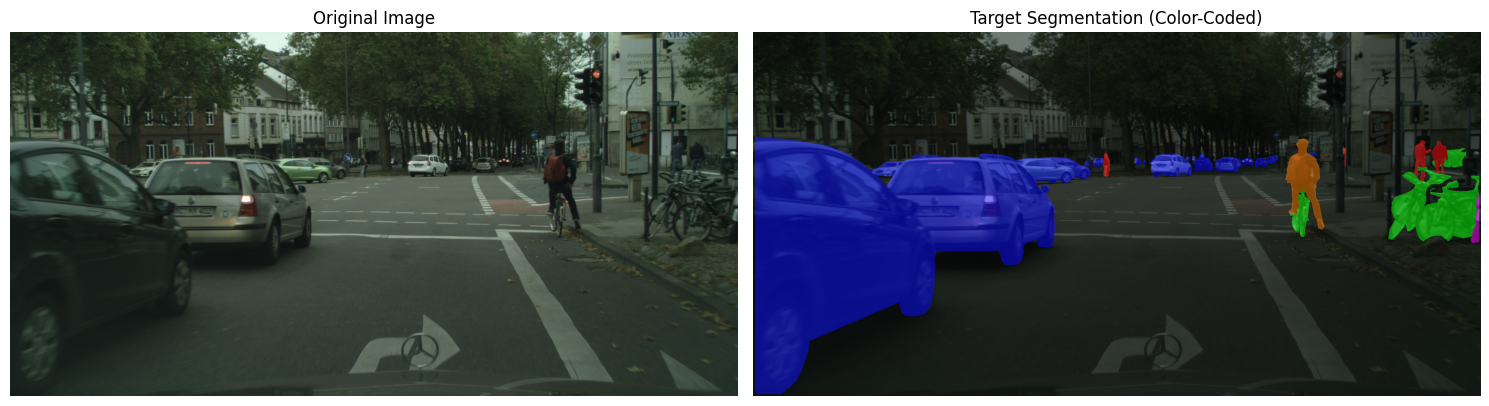

In [6]:


# --- 4. Visualization and Sanity Check ---

print("\n## 3. Visualization Check (Run this cell for output)")

def visualize_sample(img_path, mask_array, target_map):
    """Plots the image and the mask, color-coded by your target indices."""

    # Define a simple color map for the 9 target classes (0-8)
    cmap = {
        0: [0, 0, 0], 1: [255, 0, 0], 2: [255, 128, 0], 3: [0, 0, 255],
        4: [0, 128, 255], 5: [0, 255, 255], 6: [128, 0, 255], 7: [255, 0, 255],
        8: [0, 255, 0]
    }

    # Map the raw IDs to the new 0-8 target indices
    target_mask = np.vectorize(lambda x: target_map.get(x, 0))(mask_array)

    # Create the color mask
    color_mask = np.zeros((*target_mask.shape, 3), dtype=np.uint8)
    for index, color in cmap.items():
        color_mask[target_mask == index] = color

    original_img = Image.open(img_path)

    fig, ax = plt.subplots(1, 2, figsize=(15, 7))

    ax[0].imshow(original_img)
    ax[0].set_title("Original Image")
    ax[0].axis('off')

    # Overlay the color mask on the image for context
    ax[1].imshow(original_img)
    ax[1].imshow(color_mask, alpha=0.5) # alpha blending
    ax[1].set_title("Target Segmentation (Color-Coded)")
    ax[1].axis('off')

    # Print the colors/classes present in this specific image
    # present_indices = np.unique(target_mask)
    # legend_text = "\nPresent Classes:\n" + "\n".join(
    #     [f"- {target_map[i]} (Index {i})" for i in present_indices]
    # )

    plt.tight_layout()
    plt.show()

# Run visualization for the sample file
# Note: You may need to update the ID_TO_LABEL keys slightly for this function to work perfectly
# if your ID_TO_LABEL has keys that are not integers (like -1).
visualize_sample(sample_img_path, mask_array, ID_TO_LABEL)